In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from PIL import Image
from random import randint
import collections
from prettytable import PrettyTable
from IPython import display
import sklearn.datasets as skds
from sklearn.model_selection import train_test_split
!pip install learn2learn &> /dev/null
import learn2learn as l2l 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def smooth(scalars, weight = 0.9):
    last = scalars[0] 
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  
        smoothed.append(smoothed_val)                        
        last = smoothed_val

    return smoothed

#EUCLIDEAN DATASET


In [3]:
img_show = False
def generate_data(n_classes = 10, n_features = 5*4):
    X,y = skds.make_classification(n_samples=10000, n_classes=n_classes,
                                    class_sep=2.0, n_features=n_features, 
                                    n_informative=n_features, n_redundant=0,
                                    n_repeated=0, n_clusters_per_class=1)
    return X,y,n_classes

def label_to_data(X, y, n):
    data = [[] for _ in range(n)]
    for index, x in enumerate(X):
        data[y[index]].append(x)
    return data

X, y, n_classes = generate_data()
data_euclidean = label_to_data(X, y, n_classes)

def create_euclidean_dataset(data, ways, shots, tasks, classes=None):
    main_list_x_train, main_list_y_train = [],[]
    main_list_x_test,  main_list_y_test = [],[]
    for task in range(tasks):
        task_list_x_train, task_list_y_train  = [],[]
        task_list_x_test,  task_list_y_test = [],[]
        for way in range(ways):
            if classes == None:
                classes = (0, len(data)-1)
            rand_class = randint(*classes)
            curr_way = data[rand_class]
            n_samples = len(curr_way)
            for shot in range(shots):
                sample_no = randint(0, n_samples-1)
                sample = curr_way[sample_no]
                task_list_x_train.append(sample)
                task_list_y_train.append(way)
            for shot in range(shots):
                sample_no = randint(0, n_samples-1)
                sample = curr_way[sample_no]
                task_list_x_test.append(sample)
                task_list_y_test.append(way)
        size = shots*ways
        indices_train = np.random.choice(size, size, replace=False)
        indices_test = np.random.choice(size, size, replace=False)
        task_list_x_train = np.array(task_list_x_train)[indices_train]
        task_list_y_train = np.array(task_list_y_train)[indices_train]
        task_list_x_test = np.array(task_list_x_train)[indices_test]
        task_list_y_test = np.array(task_list_y_train)[indices_test]
        main_list_x_train.append(task_list_x_train)
        main_list_y_train.append(task_list_y_train)
        main_list_x_test.append(task_list_x_test)
        main_list_y_test.append(task_list_y_test)
    return [np.array(main_list_x_train), np.array(main_list_y_train),
    np.array(main_list_x_test), np.array(main_list_y_test)]

data_train_x, data_train_y= create_euclidean_dataset(data_euclidean, 5, 10, 1, classes=(0,4))[0:2]
print(data_train_x.shape, data_train_y.shape)
print(collections.Counter(data_train_y[0]))
if img_show:
    plt.imshow(data_train_x[0][3])
print(data_train_y[0][3])

(1, 50, 20) (1, 50)
Counter({1: 10, 4: 10, 0: 10, 3: 10, 2: 10})
1


# MANN with manually prepared memory

In [4]:
class neural_network(torch.nn.Module):
    def __init__(self, feature_size=3*3, hidden_size= 11, ways = 0, shots = 0, mem=(10, 11)):
        super(neural_network, self).__init__()
        self.l1 = torch.nn.LSTM(input_size = feature_size + ways, hidden_size = hidden_size)
        self.d0 = torch.nn.Linear(feature_size + ways, hidden_size)
        self.d1 = torch.nn.Linear(hidden_size+mem[-1], ways)
        self.k1 = torch.nn.Linear(hidden_size, mem[-1])
        self.alpha = torch.nn.Linear(hidden_size, mem[0])
        self.feature_size = feature_size
        self.ways = ways
        self.shots = shots
        self.hidden_size = hidden_size
        self.stored_dataset = None
        self.mem = mem

    def backprop(self, Y, labels):
        criterion = torch.nn.NLLLoss()
        loss = criterion(Y, labels)
        optimizer = torch.optim.RMSprop(self.parameters(), lr=1e-4, momentum=0.9)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss

    def forward(self, X, g, MANN, LSTM, wr, lstmh,  lstmc, memory):
        if LSTM:
            op, (lstmh,  lstmc) = self.l1(X, (lstmh,  lstmc)) # shape=> [1, 1, hidden_size]
        else:
            lstmh = self.d0(X[-1].unsqueeze(0))
        if MANN:
            key = lstmh.squeeze()
            key_final = key.unsqueeze(0) # temp
            key_final_norm = torch.sqrt(torch.sum(torch.square(key_final))) #shape => scalar
            memory_norm = torch.sqrt(torch.sum(torch.square(memory), dim = 1)) # shape => scalar
            dist_prod = (key_final_norm* memory_norm) # shape => scalar
            #read
            z = memory@(key_final.permute((1,0))) #shape => [slots, 1]
            z = (z.squeeze()/dist_prod).unsqueeze(1) #shape => [slots, 1]
            wr = torch.nn.functional.softmax(z, dim=0) #shape => [slots, 1]
            rt = wr.permute((1,0))@memory #shape => [1, mem_size]
        else:
            rt = torch.zeros((1, memory.size()[-1]))
        y_lstm_1_last = torch.cat((lstmh.squeeze(), rt.squeeze())) # shape => [hidden_size + mem_size]
        y_d1 = torch.nn.functional.relu(self.d1(y_lstm_1_last))
        pred = torch.nn.functional.log_softmax(y_d1, dim=-1) #shape => [ways]
        return pred, wr, lstmh,  lstmc, memory

    def batched_training(self, X, y_test, g, MANN, LSTM, train, memory, mini_batch = 1):
        wr = torch.rand((memory.size()[0], 1)) # shape => [slots]
        lstmh,  lstmc = torch.zeros((1,1,self.hidden_size)), torch.zeros((1,1,self.hidden_size)) # shape => [1, 1, hidden_state]
        train_loss = 0
        y_batch = torch.empty((0, self.ways))
        for index in range(0, X.size()[0], mini_batch):
            mini_batch  = min(index + mini_batch, X.size()[0]) - index
            x = X[index: index + mini_batch] #shape => [mini_batch, 1, features]
            y, wr, lstmh, lstmc, memory = self.forward(x, g, MANN, LSTM, wr, lstmh,  lstmc, memory)
            y_batch = torch.cat((y_batch, y.unsqueeze(0)))
        if train:
            train_loss = self.backprop(y_batch, y_test)
        return train_loss, y_batch

    def run_episodes(self, data, task_creator, MANN, LSTM, update_dataset = True, train=True):
        if self.stored_dataset == None and not update_dataset:
            self.stored_dataset = task_creator(data, self.ways, self.shots, 1)[0:2]
        if update_dataset:
            self.stored_dataset = task_creator(data, self.ways, self.shots, 1)[0:2]
        data_train_x, data_train_y = self.stored_dataset
        data_train_x = torch.from_numpy(data_train_x) # shape => [tasks, (shotsxways), featuresX, featuresY]
        data_train_y = torch.from_numpy(data_train_y) # shape => [tasks, (shotsxways)]
        y_prev = torch.tensor([0])
        y_test = data_train_y[0] # shape => [(shotsxways)]
        X = torch.empty((0, self.feature_size + self.ways)).to(device)
        memory = torch.empty((0, self.mem[-1])) #temp
        for index, curr_x in enumerate(data_train_x[0]):
            y_prev_henc = torch.eye(self.ways) # shape => [ways, ways]
            y_prev_henc = y_prev_henc[y_prev].squeeze() # shape => [ways]
            flattened_x = curr_x.reshape(-1) # shape => [features]
            curr_X = torch.cat((flattened_x, y_prev_henc)).reshape(1, -1) # shape => [1, features + ways]
            X = torch.cat((X, curr_X)) # shape => [(shotsxways), features]
            y_prev = data_train_y[0][index] # shape => scalar
            y_prev_henc = torch.eye(self.ways) # temp
            y_prev_henc = y_prev_henc[y_prev].squeeze() #temp
            curr_mem =  torch.cat((flattened_x, y_prev_henc)).reshape(1, -1) #temp
            memory = torch.cat((memory, curr_mem))  #temp
            memory = memory.float() #temp        
        X = torch.unsqueeze(X, 1) #shape => [(shotsxways), 1, features]
        X = X.float()
        episode_loss, pred= self.batched_training(X, y_test, 0.95, MANN, LSTM, train, memory)
        return X, y_test, torch.exp(pred), episode_loss

    def accuracy(self, y_pred, labels):
        prev_labels = {}
        acc_dict = {}
        y_pred = y_pred.detach().numpy()
        labels = labels.detach().numpy()
        for index, label in enumerate(labels):
            pred_dec = np.argmax(y_pred[index]).item()
            label_dec = labels[index]
            if prev_labels.get(label_dec, None)  != None:
                prev_labels[label_dec] += 1
                if pred_dec == label_dec:
                    acc_dict[label_dec].append(1)
                else:
                    acc_dict[label_dec].append(0)
            else:
                prev_labels[label_dec] = 1
                if pred_dec == label_dec:
                    acc_dict[label_dec] = [1]
                else:
                    acc_dict[label_dec] = [0]
        return acc_dict

def init_nn():
    nn = neural_network(ways = 2, shots = 5)
    return nn

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
nn = init_nn()   
print(count_parameters(nn))
print(nn)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| l1.weight_ih_l0 |    484     |
| l1.weight_hh_l0 |    484     |
|  l1.bias_ih_l0  |     44     |
|  l1.bias_hh_l0  |     44     |
|    d0.weight    |    121     |
|     d0.bias     |     11     |
|    d1.weight    |     44     |
|     d1.bias     |     2      |
|    k1.weight    |    121     |
|     k1.bias     |     11     |
|   alpha.weight  |    110     |
|    alpha.bias   |     10     |
+-----------------+------------+
Total Trainable Params: 1486
1486
neural_network(
  (l1): LSTM(11, 11)
  (d0): Linear(in_features=11, out_features=11, bias=True)
  (d1): Linear(in_features=22, out_features=2, bias=True)
  (k1): Linear(in_features=11, out_features=11, bias=True)
  (alpha): Linear(in_features=11, out_features=10, bias=True)
)


Text(0, 0.5, 'Training loss')

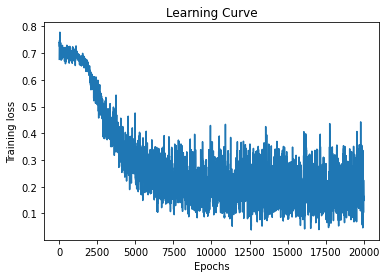

In [5]:
no_epochs = 20000
show_after = 1000
X, y, n_classes = generate_data(n_classes=5, n_features=3*3)
data_euclidean = label_to_data(X, y, n_classes)
plot_accuracy_no_write = []
plot_loss = []
loss_history = []
nn = init_nn()
epoch = 0
while epoch < no_epochs:
    x, y, pred, loss = nn.run_episodes(data_euclidean, create_euclidean_dataset, 
                                       update_dataset=True, MANN=True, LSTM=True)
    accuracy_dict = nn.accuracy(pred, y)
    correct_preds = 0
    for a, b in accuracy_dict.items():
            correct_preds+=sum(b)
    plot_accuracy_no_write.append(correct_preds/(nn.ways*nn.shots))
    plot_loss.append(loss.item())
    if epoch%show_after == 0:
        print(f"Epoch %.4d:  Loss = %f Avg Acc = %f" % (epoch, loss.item(),
                                                    correct_preds/(nn.ways*nn.shots)))
        display.clear_output(wait=True)
        loss_history.append(loss.item())
        if (len(loss_history)>=3 and 
        loss_history[-1] == loss_history[-2] and
        loss_history[-2] == loss_history[-3]):
            nn = init_nn()
            print("Stuck, Resetting...")
            plot_accuracy_no_write.clear()
            plot_loss.clear()
            loss_history.clear()
            epoch = 0
            continue
    epoch += 1

fig1, ax1 = plt.subplots()
ax1.plot(smooth(plot_loss))
ax1.set_title('Learning Curve')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training loss")

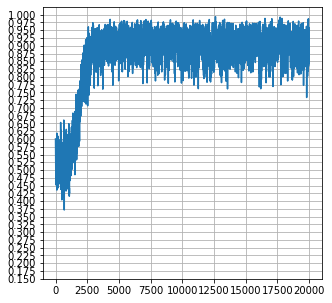

In [6]:
fg, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(smooth(plot_accuracy_no_write, 0.90))
ax.set_yticks(np.arange(0.15, 1.01, step=0.025))
ax.grid(True)

# MANN 

In [7]:
class neural_network(torch.nn.Module):
    def __init__(self, feature_size=5*4, hidden_size=26, ways = 0, shots=0, mem=(20, 26), nreads=2, batch=1):
        super(neural_network, self).__init__()
        self.l1 = torch.nn.LSTM(input_size = feature_size + ways, hidden_size = hidden_size).to(device)
        self.d0 = torch.nn.Linear(feature_size + ways, hidden_size).to(device)
        self.d1 = torch.nn.Linear(hidden_size + nreads*mem[-1], ways).to(device)
        self.kr = torch.nn.Linear(2*hidden_size, mem[-1] * nreads).to(device)
        self.kw = torch.nn.Linear(2*hidden_size, mem[-1] * nreads).to(device)
        self.alpha = torch.nn.Linear(2*hidden_size, mem[0]).to(device)
        self.feature_size = feature_size
        self.ways = ways
        self.shots = shots
        self.hidden_size = hidden_size
        self.stored_dataset = None
        self.mem = mem
        self.nreads = nreads
        self.batch = batch
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr=5e-5, momentum=0.90)
        self.criterion = torch.nn.NLLLoss()

    def backprop(self, Y, labels):
        loss = self.criterion(Y, labels)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss

    def forward(self, X, g, MANN, LSTM, wu, wr, lstmh,  lstmc, memory):
        if LSTM:
            op, (lstmh,  lstmc) = self.l1(X, (lstmh,  lstmc)) # shape=> [1, batch, hidden_size]
        else:
            lstmh = self.d0(X[-1].unsqueeze(0))
        if MANN:
            key = torch.cat((lstmh.reshape(self.batch, -1),  lstmc.reshape(self.batch, -1)), dim=1)# shape => [batch, 2*hidden_size]
            #least recently used
            wlu = wu.clone().detach() # shape => [batch, slots, nreads]
            k_sm_wu = wu.sort(dim=1)[1] # shape => [batch, slots, nreads]
            rem_indx = (k_sm_wu < self.nreads)
            wlu[rem_indx] = 1
            wlu[~rem_indx] = 0

            #write
            write_key = torch.tanh(self.kw(key)).reshape(self.batch, self.nreads, -1) #shape => [batch, nreads, mem_size]
            sigma = torch.tanh(self.alpha(key)) #shape => [batch, slots]
            ww = (sigma*(wr.permute(2,0,1)) + (1-sigma)*(wlu.permute(2,0,1))).permute(1,2,0) # shape => [batch, slots, nreads]
            memory = memory +ww@write_key  #shape => [batch, slots, mem_size]
            #read
            read_key = torch.tanh(self.kr(key)).reshape(self.batch, self.nreads, -1)  #shape => [batch, nreads, mem_size]
            read_key_norm = torch.sqrt(torch.sum(torch.square(read_key), dim=-1)) #shape => [batch, nreads]
            memory_norm = torch.sqrt(torch.sum(torch.square(memory), dim=[1,-1])) # shape => [batch]
            dist_prod = ((read_key_norm.permute(1,0))* memory_norm).permute(1,0) # shape => [batch, nreads]

            z = memory@(read_key.permute((0,2,1))) #shape => [batch, slots, nreads]
            z = (z.permute(1,0,2)/dist_prod).permute(1,0,2) #shape => [batch, slots, nreads]
            wr = torch.nn.functional.softmax(z, dim=1) #shape => [batch, slots, nreads]
            rt = wr.permute((0,2,1))@memory #shape => [batch, nreads, mem_size]

            wu = g*wu + wr + ww # shape => [batch, slots, nreads]
        else:
            rt = torch.rand((self.batch, self.nreads, memory.size()[-1]))
        y_lstm_1_last = torch.cat((lstmh.reshape(self.batch, -1), rt.reshape(self.batch, -1)), dim=1) # shape => [batch,  hidden_size + nreads*mem_size]
        y_d1 = torch.nn.functional.relu(self.d1(y_lstm_1_last)) # shape => [batch, ways]
        pred = torch.nn.functional.log_softmax(y_d1, dim=-1) #shape => [batch, ways]
        return pred, wu, wr, lstmh,  lstmc, memory

    def batched_training(self, X, y_test, g, MANN, LSTM, train):
        memory = 1e-6*torch.ones(self.batch, *self.mem).to(device) # shape => [batch, slots, mem_size]
        wr = torch.randint(0, 2,(self.batch, self.mem[0], self.nreads)).to(device) # shape => [batch, slots, nreads]
        wu = torch.randint(0, 2,(self.batch, self.mem[0], self.nreads)) .to(device)# shape => [batch, slots, nreads]
        lstmh,  lstmc = torch.zeros((1,self.batch,self.hidden_size)).to(device), torch.zeros((1,self.batch,self.hidden_size)).to(device) # shape => [1, batch, hidden_state]
        train_loss = 0
        y_batch = torch.empty((self.batch, 0, self.ways)).to(device)
        for index in range(0, X.size()[0], 1):
            x = X[index: index + 1] #shape => [1, batch, features]
            y, wu, ww, lstmh, lstmc, memory = self.forward(x, g, MANN, LSTM, wu, wr, lstmh,  lstmc, memory)
            y_batch = torch.cat((y_batch, y.unsqueeze(1)), dim=1)  #shape => [shots*ways, batch, ways]
        if train:
            train_loss = self.backprop(y_batch.reshape(-1, self.ways), y_test. reshape(-1))
        return train_loss, y_batch

    def run_episodes (self, data, task_creator, MANN, LSTM, classes, update_dataset = True, train=True):
        if self.stored_dataset == None or update_dataset:
            self.stored_dataset = task_creator(data, self.ways, self.shots, self.batch, classes)[0:2]
        data_train_x, data_train_y = self.stored_dataset
        data_train_x = torch.from_numpy(data_train_x).to(device) # shape => [batch, (shotsxways), featuresX, featuresY]
        data_train_y = torch.from_numpy(data_train_y).to(device) # shape => [batch, (shotsxways)]
        y_test = data_train_y # shape => [batch, (shotsxways)]
        batch_X = torch.empty((self.ways*self.shots, 0, self.feature_size + self.ways)).to(device)
        for cur_batch in range(self.batch):
            y_prev = torch.tensor([0]).to(device) #shape = [batch]
            X = torch.empty((0, self.feature_size + self.ways)).to(device)
            for index, curr_x in enumerate(data_train_x[cur_batch]):
                y_prev_henc = torch.eye(self.ways).to(device) # shape => [ways, ways]
                y_prev_henc = y_prev_henc[y_prev].squeeze() # shape => [ways]
                flattened_x = curr_x.reshape(-1) # shape => [features]
                curr_X = torch.cat((flattened_x, y_prev_henc)).reshape(1, -1) # shape => [1, features + ways]
                X = torch.cat((X, curr_X)) # shape => [(shotsxways), features]
                y_prev = data_train_y[0][index] # shape => scalar
            X = torch.unsqueeze(X, 1) #shape => [(shotsxways), 1, features]
            X = X.float()
            batch_X = torch.cat((batch_X, X), dim=1) #shape => [(shotsxways), batch, features]
        episode_loss, pred= self.batched_training(batch_X, y_test, 0.95, MANN, LSTM, train)
        return X, y_test, torch.exp(pred), episode_loss

    def accuracy(self, y_pred, labels):
        prev_labels = {}
        acc_dict = {}
        y_pred = y_pred.detach().numpy()
        labels = labels.detach().numpy()
        for index, label in enumerate(labels):
            pred_dec = np.argmax(y_pred[index]).item()
            label_dec = labels[index]
            if prev_labels.get(label_dec, None)  != None:
                prev_labels[label_dec] += 1
                if pred_dec == label_dec:
                    acc_dict[label_dec].append(1)
                else:
                    acc_dict[label_dec].append(0)
            else:
                prev_labels[label_dec] = 1
                if pred_dec == label_dec:
                    acc_dict[label_dec] = [1]
                else:
                    acc_dict[label_dec] = [0]
        return acc_dict

def init_nn():
    nn = neural_network(ways = 2, shots = 5)
    return nn

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

nn = init_nn()   
print(count_parameters(nn))
print(nn)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| l1.weight_ih_l0 |    2288    |
| l1.weight_hh_l0 |    2704    |
|  l1.bias_ih_l0  |    104     |
|  l1.bias_hh_l0  |    104     |
|    d0.weight    |    572     |
|     d0.bias     |     26     |
|    d1.weight    |    156     |
|     d1.bias     |     2      |
|    kr.weight    |    2704    |
|     kr.bias     |     52     |
|    kw.weight    |    2704    |
|     kw.bias     |     52     |
|   alpha.weight  |    1040    |
|    alpha.bias   |     20     |
+-----------------+------------+
Total Trainable Params: 12528
12528
neural_network(
  (l1): LSTM(22, 26)
  (d0): Linear(in_features=22, out_features=26, bias=True)
  (d1): Linear(in_features=78, out_features=2, bias=True)
  (kr): Linear(in_features=52, out_features=52, bias=True)
  (kw): Linear(in_features=52, out_features=52, bias=True)
  (alpha): Linear(in_features=52, out_features=20, bias=True)
  (criterion): NLLLoss()
)


Text(0, 0.5, 'Training loss')

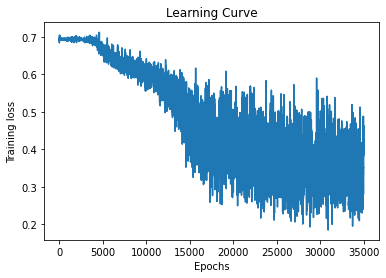

In [8]:
no_epochs = 35000
show_after = 1000
X, y, n_classes = generate_data(n_classes=7, n_features=5*4)
data_euclidean = label_to_data(X, y, n_classes)
plot_accuracy = []
plot_loss = []
acc_on = (1,5)
loss_history = []
epoch = 0
nn = init_nn()
while epoch < no_epochs:
    x, y, pred, loss = nn.run_episodes(data_euclidean, create_euclidean_dataset, update_dataset=True, MANN=True, LSTM=True, classes=(0, 4))
    accuracy_dict = nn.accuracy(pred.reshape(-1, nn.ways), y. reshape(-1))
    correct_preds = 0
    for a, b in accuracy_dict.items():
            correct_preds+=sum(b[acc_on[0]:acc_on[1]])
    plot_accuracy.append(correct_preds/(nn.ways*(acc_on[1]-acc_on[0])*nn.batch))
    plot_loss.append(loss.item())
    if epoch%show_after == 0:
        curr_lr = nn.optimizer.param_groups[0]['lr']
        print(f"Epoch %.4d:  Loss = %f, Avg Acc = %f"%(epoch, loss.item(), 
        (correct_preds/(nn.ways*(acc_on[1]-acc_on[0])*nn.batch))))
        display.clear_output(wait=True)
        loss_history.append(loss.item())
        if (len(loss_history)>=3 and 
        loss_history[-1] == loss_history[-2] and
        loss_history[-2] == loss_history[-3]):
            nn = init_nn()
            print("Stuck, Resetting...")
            plot_accuracy.clear()
            plot_loss.clear()
            loss_history.clear()
            epoch = 0
            continue
    epoch += 1
fig1, ax1 = plt.subplots()
ax1.plot(smooth(plot_loss))
ax1.set_title('Learning Curve')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training loss")

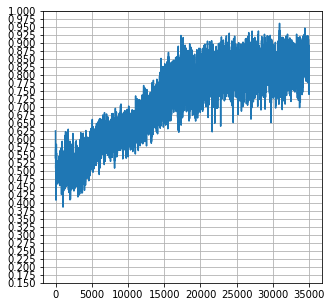

In [9]:
fg, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(smooth(plot_accuracy, 0.90))
ax.set_yticks(np.arange(0.15, 1.01, step=0.025))
ax.grid(True)

##META-TESTING: MANN

Text(0, 0.5, 'testaccuracy')

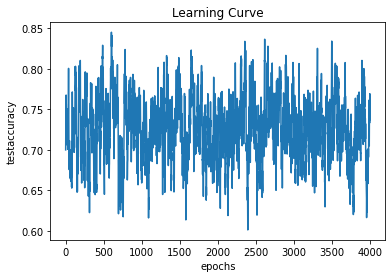

In [10]:
no_epochs = 4000
plot_accuracy_test = []
acc_on = (0,5)
for epoch in range(no_epochs):
    x, y, pred, loss = nn.run_episodes(data_euclidean, create_euclidean_dataset,update_dataset=True,
    MANN=True, LSTM=True, train=False, classes=(2, 6))
    accuracy_dict = nn.accuracy(pred.reshape(-1, nn.ways), y. reshape(-1))
    correct_preds = 0
    for a, b in accuracy_dict.items():
            correct_preds+=sum(b[acc_on[0]:acc_on[1]])
    plot_accuracy_test.append(correct_preds/(nn.ways*(acc_on[1]-acc_on[0])*nn.batch))
fig2, ax2 = plt.subplots()
ax2.plot(smooth(plot_accuracy_test))
ax2.set_title('Learning Curve')
ax2.set_xlabel("epochs")
ax2.set_ylabel("testaccuracy")

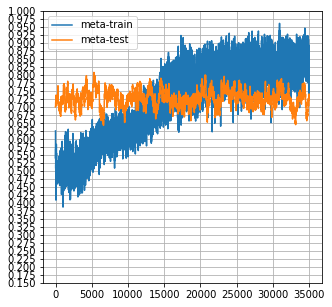

In [11]:
fg, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(smooth(plot_accuracy, 0.90), label='meta-train')
ax.plot(np.array(smooth(plot_accuracy_test, 0.95)) \
[np.linspace(0, len(plot_accuracy_test)-1, len(plot_accuracy), dtype='int')], label='meta-test')
ax.set_yticks(np.arange(0.15, 1.01, step=0.025))
ax.legend(loc='best')
ax.grid(True)

#CNP

In [12]:
class MLP(torch.nn.Module):
    def __init__(self,dims=[5,3,2],task='classification',lr=1e-3):
        super(MLP,self).__init__()
        self.dims=dims
        self.n = len(self.dims)-1
        self.task=task
        self.layers=torch.nn.ModuleList()
        for i in range(self.n-1):
            self.layers.append(torch.nn.Linear(dims[i],dims[i+1]))
            self.layers.append(torch.nn.ReLU())
        if task=='classification': 
            self.layers.append(torch.nn.Linear(dims[i+1],dims[i+2]))
            self.layers.append(torch.nn.LogSoftmax(dim=1))
        elif task=='regression': 
            self.layers.append(torch.nn.Linear(dims[i+1],dims[i+2]))
            self.layers.append(torch.nn.Linear(dims[i+2],1))
        else: self.layers.append(torch.nn.Linear(dims[i+1],dims[i+2]))
        self.optimizer = torch.optim.Adam(self.parameters(),lr=lr)
    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return(x)

class CNP(torch.nn.Module):
    def __init__(self,n_features=1,dims=[32,32],n_classes=2,lr=1e-4):
        super(CNP,self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        dimL1 = [n_features]+dims
        dimL2=[n_features+n_classes*dims[-1]]+dims+[n_classes]
        self.mlp1 = MLP(dims=dimL1,task='embedding')
        self.mlp2 = MLP(dims=dimL2)
        self.optimizer=torch.optim.Adam(self.parameters(),lr=lr)
    def adapt(self,X,y):
        R = self.mlp1(X)
        m = torch.eye(self.n_classes)[y].transpose(0,1)/self.n_classes
        r = (m@R).flatten().unsqueeze(0)
        #r = (R.sum(dim=0)/X.shape[0]).unsqueeze(0)
        return r
    def forward(self,Y,r):
        rr = r.repeat(Y.shape[0],1)
        p = self.mlp2(torch.cat((Y,rr),dim=1))
        return p

def accuracy(Net,X_test,y_test,h,verbose=True):
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    return accuracy

In [13]:
shots,ways = 5, 2
net = CNP(n_features=20,n_classes=ways,dims=[32,64,32],lr=1e-4)
print(count_parameters(net))
lossfn = torch.nn.NLLLoss()
meta_train_kloader=create_euclidean_dataset
meta_test_kloader=create_euclidean_dataset
cnp_train_acc = []
cnp_test_acc_arr = []

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
| mlp1.layers.0.weight |    640     |
|  mlp1.layers.0.bias  |     32     |
| mlp1.layers.2.weight |    2048    |
|  mlp1.layers.2.bias  |     64     |
| mlp1.layers.4.weight |    2048    |
|  mlp1.layers.4.bias  |     32     |
| mlp2.layers.0.weight |    2688    |
|  mlp2.layers.0.bias  |     32     |
| mlp2.layers.2.weight |    2048    |
|  mlp2.layers.2.bias  |     64     |
| mlp2.layers.4.weight |    2048    |
|  mlp2.layers.4.bias  |     32     |
| mlp2.layers.6.weight |     64     |
|  mlp2.layers.6.bias  |     2      |
+----------------------+------------+
Total Trainable Params: 11842
11842


In [14]:
epoch=0
n_epochs=1000
task_count=10
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    #Sample and train on a task
    for task in range(task_count):
        x,y,a,b = meta_train_kloader(data_euclidean, ways, shots, 1, classes=(0,4))
        x,y,a,b = torch.tensor(x).squeeze(),torch.tensor(y).squeeze(),torch.tensor(a).squeeze(),torch.tensor(b).squeeze()
        d_train = [x.float(),y]
        d_test = [a.float(),b]
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        x_tr = d_train0
        d_tr = x_tr 
        h = net.adapt(d_tr,d_train1)
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        y_ts_sh = torch.zeros(x_ts.shape[0],ways)
        d_ts = x_ts 
        test_preds = net(d_ts,h)
        train_preds = net(d_tr,h)
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1)+lossfn(train_preds,d_train1)
        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,h,verbose=False)
        net.train()
    #Update the network weights
    print('Epoch %.4d: Loss %f Avg Acc %f'%(epoch,test_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    cnp_train_acc.append(test_acc/task_count)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1

Epoch 0999: Loss 0.639312 Avg Acc 0.820000


##META-TESTING: CNP

In [15]:
epoch=0
n_epochs=1000
task_count=10
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        x,y,a,b = meta_train_kloader(data_euclidean, ways, shots, 1, classes=(2,6))
        x,y,a,b = torch.tensor(x).squeeze(),torch.tensor(y).squeeze(),torch.tensor(a).squeeze(),torch.tensor(b).squeeze()
        d_train = [x.float(),y]
        d_test = [a.float(),b]
        x_tr = d_train[0]
        y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
        d_tr = x_tr 
        h=net.adapt(d_tr,d_train[1])
        x_ts = d_test[0]
        y_ts_sh = torch.zeros(x_ts.shape[0],ways)
        d_ts = x_ts
        test_preds = net(d_ts,h)
        test_acc += accuracy(net,d_ts,d_test[1],h,verbose=False)
        # Done with a task
    cnp_test_acc_arr.append(test_acc/task_count)
    epoch+=1

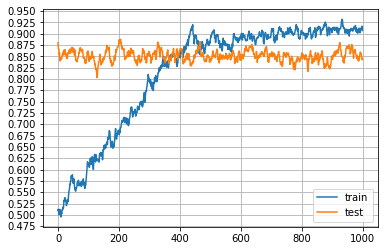

In [16]:
fg, ax= plt.subplots()
ax.set_yticks(np.arange(0.10, 1.01, step=0.025))
ax.plot(smooth(cnp_train_acc, 0.9), label ='train')
ax.plot(smooth(cnp_test_acc_arr, 0.9), label='test')
ax.grid(True)
ax.legend(loc='best')

#MAML

In [17]:
def accuracy(Net,X_test,y_test,verbose=True):
    Net.eval()
    m = X_test.shape[0]
    y_pred = Net(X_test)
    predicted = torch.max(y_pred, 1)[1]
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    Net.train()
    return accuracy

In [18]:
shots,ways = 5,2
net = MLP(dims=[20,64,32,ways])
maml = l2l.algorithms.MAML(net, lr=1e-2)
optimizer = torch.optim.Adam(maml.parameters(),lr=5e-3)
lossfn = torch.nn.NLLLoss()
meta_train_kloader=create_euclidean_dataset
maml_train_acc_arr = []
maml_test_acc_arr = []

In [19]:
n_epochs=200
task_count=50
fas = 1
epoch=0
while epoch<n_epochs:
    adapt_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        x,y,a,b = meta_train_kloader(data_euclidean, ways, shots, 1, classes=(0,4))
        x,y,a,b = torch.tensor(x).squeeze(),torch.tensor(y).squeeze(),torch.tensor(a).squeeze(),torch.tensor(b).squeeze()
        d_train = [x.float(),y]
        d_test = [a.float(),b]
        learner = maml.clone()
        for fas_step in range(fas):
            train_preds = learner(d_train[0])
            train_loss = lossfn(train_preds,d_train[1])
            learner.adapt(train_loss)
        test_preds = learner(d_test[0])
        adapt_loss += lossfn(test_preds,d_test[1])
        learner.eval()
        test_acc += accuracy(learner,d_test[0],d_test[1],verbose=False)
        learner.train()
        # Done with a task
    # Update main network
    print('Epoch %.4d:  Loss=%f Avg Acc=%f'%(epoch,adapt_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    maml_train_acc_arr.append(test_acc/task_count)
    optimizer.zero_grad()
    total_loss = adapt_loss
    total_loss.backward()
    optimizer.step()
    epoch+=1

Epoch 0199:  Loss=0.181472 Avg Acc=0.940000


##META-TESTING: MAML

In [20]:
n_epochs=200
task_count=50
adapt_steps = 2
epoch=0
while epoch<n_epochs:
    test_acc = 0.0
    meta_test_kloader=create_euclidean_dataset
    test_acc = 0.0
    maml.eval()
    # Sample and train on a task
    for task in range(task_count):
        x,y,a,b = meta_train_kloader(data_euclidean, ways, shots, 1, classes=(2,6))
        x,y,a,b = torch.tensor(x).squeeze(),torch.tensor(y).squeeze(),torch.tensor(a).squeeze(),torch.tensor(b).squeeze()
        d_train = [x.float(),y]
        d_test = [a.float(),b]
        learner = maml.clone()
        learner.eval()
        for adapt_step in range(adapt_steps):
            train_preds = learner(d_train[0])
            train_loss = lossfn(train_preds,d_train[1])
            learner.adapt(train_loss)
        test_preds = learner(d_test[0])
        test_acc += accuracy(learner,d_test[0],d_test[1],verbose=False)
        # Done with a task
    learner.train()
    maml_test_acc_arr.append(test_acc/task_count)
    epoch += 1

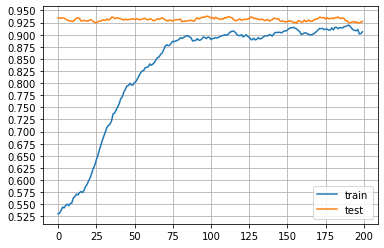

In [21]:
fg, ax= plt.subplots()
ax.set_yticks(np.arange(0.10, 1.01, step=0.025))
ax.plot(smooth(maml_train_acc_arr, 0.9), label ='train')
ax.plot(smooth(maml_test_acc_arr, 0.9), label='test')
ax.grid(True)
ax.legend(loc='best')

# MATCHING NETWORKS

In [22]:
class Cos(torch.nn.Module):
    def __init__(self,dims=[20,32,32]):
        super(Cos,self).__init__()
    def forward(self,target,ss):
        # compute cosine distances between 
        # target (batch,embedding_dim) and support set ss (ss_size,embedding_dim)
        # return (batch,ss_size)
        target_normed = torch.nn.functional.normalize(target,p=2,dim=1)
        # shape of target_normed will be (batch,1,embedding_dim)
        ss_normed = torch.nn.functional.normalize(ss,p=2,dim=1).permute(1,0)
        similarities = torch.mm(target_normed,ss_normed)
        # result will be (batch,ss_size)
        return similarities
class MAN(torch.nn.Module):
    def __init__(self,dims=[20,32,32],n_classes=2,lr=1e-3):
        super(MAN,self).__init__()
        self.n_classes = n_classes
        self.mlp = MLP(dims=dims,task='embedding')
        self.cos = Cos()
        self.attn = torch.nn.Softmax(dim=1)
        self.optimizer = torch.optim.Adam(self.parameters(),lr=lr)
    def forward(self,X,d_train):
        # X = (batch,n_features)
        (x_tr,y_tr) = d_train
        # x_tr = (ss_size,n_features), y_tr = (ss_size)
        ss_e = self.mlp(x_tr)
        X_e = self.mlp(X)
        sims = self.cos(X_e,ss_e)
        # size (batch,ss_size)
        attn_wts = self.attn(sims)
        y_h = torch.eye(self.n_classes)[y_tr]
        # y_h = one-hot version of y_tr = (ss_size,n_classes)
        preds = attn_wts@y_h
        return preds
def accuracy(Net,X_test,y_test,h,verbose=True):
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    return accuracy

In [23]:
X, y, n_classes = generate_data(n_classes=10, n_features=5*4)
data_euclidean = label_to_data(X, y, n_classes)
shots,ways = 5,2
net = MAN(n_classes=ways,dims=[20,64,32],lr=1e-4)
lossfn = torch.nn.NLLLoss()
meta_train_kloader = create_euclidean_dataset
match_train_acc_arr, match_test_acc_arr = [],[]

In [24]:
epoch=0
n_epochs=100
task_count=50
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        x,y,a,b = meta_train_kloader(data_euclidean, ways, shots, 1, classes=(0,4))
        x,y,a,b = torch.tensor(x).squeeze(),torch.tensor(y).squeeze(),torch.tensor(a).squeeze(),torch.tensor(b).squeeze()
        d_train = [x.float(),y]
        d_test = [a.float(),b]
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        x_tr = d_train0
        d_tr = x_tr 
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        d_ts = x_ts 
        test_preds = net(d_ts,(x_tr,d_train1))
        #train_preds = net(d_tr,h)
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1)
        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,(x_tr,d_train1),verbose=False)
        net.train()
    #Update the network weights
    print('Epoch %.4d Loss: %f Avg Acc: %f'%(epoch,test_loss/task_count,test_acc/(task_count)))
    display.clear_output(wait=True)
    match_train_acc_arr.append(test_acc/task_count)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1

Epoch 0099 Loss: -0.611540 Avg Acc: 0.958000


##META-TESTING: Matching Networks

In [25]:
epoch=0
n_epochs=100
task_count=50
meta_train_kloader = create_euclidean_dataset
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        x,y,a,b = meta_train_kloader(data_euclidean, ways, shots, 1, classes=(0,4))
        x,y,a,b = torch.tensor(x).squeeze(),torch.tensor(y).squeeze(),torch.tensor(a).squeeze(),torch.tensor(b).squeeze()
        d_train = [x.float(),y]
        d_test = [a.float(),b]
        x_tr = d_train[0]
        y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
        d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
        x_ts = d_test[0]
        y_ts_sh = torch.zeros(x_ts.shape[0],ways)
        d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
        test_preds = net(d_ts,(d_tr,d_train[1]))
        test_acc += accuracy(net,d_ts,d_test[1],(d_tr,d_train[1]),verbose=False)
        # Done with a task
    net.train()
    match_test_acc_arr.append(test_acc/task_count)
    epoch +=1

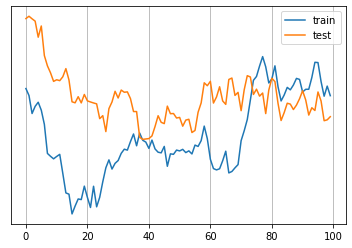

In [26]:
fg, ax= plt.subplots()
ax.set_yticks(np.arange(0.80, 1.01, step=0.025))
ax.plot(smooth(match_train_acc_arr, 0.9), label ='train')
ax.plot(smooth(match_test_acc_arr, 0.9), label='test')
ax.grid(True)
ax.legend(loc='best')

#COMBINED PERFORMANCE

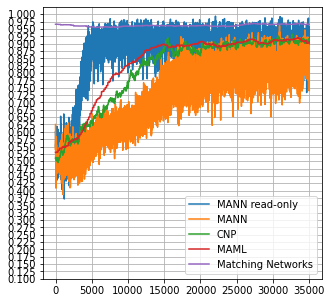

In [27]:
fg, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(np.array(smooth(plot_accuracy_no_write))[np.linspace(0, len(plot_accuracy_no_write)-1, 35000, dtype='int')], label='MANN read-only')
ax.plot(np.array(smooth(plot_accuracy))[np.linspace(0, len(plot_accuracy)-1, 35000, dtype='int')], label='MANN')
ax.plot(np.array(smooth(cnp_train_acc))[np.linspace(0, len(cnp_train_acc)-1, 35000, dtype='int')], label='CNP')
ax.plot(np.array(smooth(maml_train_acc_arr))[np.linspace(0, len(maml_train_acc_arr)-1, 35000, dtype='int')], label='MAML')
ax.plot(np.array(smooth(match_train_acc_arr))[np.linspace(0, len(match_train_acc_arr)-1, 35000, dtype='int')], label='Matching Networks')
ax.set_yticks(np.arange(0.1, 1.01, step=0.025))
ax.grid(True)
ax.legend(loc='best')

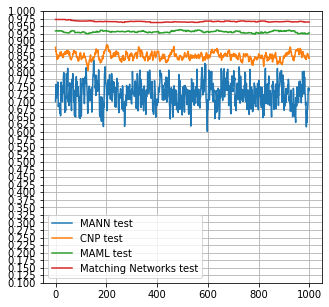

In [28]:
fg, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(np.array(smooth(plot_accuracy_test))[np.linspace(0, len(plot_accuracy_test)-1, 1000, dtype='int')], label='MANN test')
ax.plot(np.array(smooth(cnp_test_acc_arr))[np.linspace(0, len(cnp_test_acc_arr)-1, 1000, dtype='int')], label='CNP test')
ax.plot(np.array(smooth(maml_test_acc_arr))[np.linspace(0, len(maml_test_acc_arr)-1, 1000, dtype='int')], label='MAML test')
ax.plot(np.array(smooth(match_test_acc_arr))[np.linspace(0, len(match_test_acc_arr)-1, 1000, dtype='int')], label='Matching Networks test')
ax.set_yticks(np.arange(0.1, 1.01, step=0.025))
ax.grid(True)
ax.legend(loc='best')

#MANN on OMNIGLOT


In [29]:
new_shape = (28, 28)
imagenet_data_back = tv.datasets.Omniglot('/content/sample_data/Omniglot', download=True, background=True)
imagenet_data_eval = tv.datasets.Omniglot('/content/sample_data/Omniglot', download=True, background=False)


Extracting /content/sample_data/Omniglot/omniglot-py/images_background.zip to /content/sample_data/Omniglot/omniglot-py



Extracting /content/sample_data/Omniglot/omniglot-py/images_evaluation.zip to /content/sample_data/Omniglot/omniglot-py


In [30]:
def image_array(home, im_path, new_shape):
    path = os.path.join(home, im_path)
    main_list = os.listdir(path)
    image_list_main = []
    for folder in main_list:
        char_list = os.listdir(os.path.join(path, folder))
        image_list_folder = []
        for char in char_list:
            img_list = os.listdir(os.path.join(path, folder, char))
            image_list_char = []
            for img in img_list:
                img_arr = Image.open(os.path.join(path, folder, char, img))
                img_arr.thumbnail(new_shape, Image.ANTIALIAS) 
                img_arr = np.asarray(img_arr, dtype=np.float) 
                image_list_char.append(img_arr)
            image_list_folder.append(image_list_char)
        image_list_main.append(np.asarray(image_list_folder))
    return image_list_main
home = '/content/sample_data'
path1 = 'Omniglot/omniglot-py/images_background'
path2 = 'Omniglot/omniglot-py/images_evaluation'
imgs_train = image_array(home, path1, new_shape)
imgs_test = image_array(home, path2, new_shape)

(1, 10, 28, 28) (1, 10)
Counter({0: 5, 1: 5})
Counter({0: 5, 1: 5})
Counter({0: 5, 1: 5})
Counter({0: 5, 1: 5})
Counter({0: 5, 1: 5})
Counter({0: 5, 1: 5})
Counter({0: 5, 1: 5})
Counter({0: 5, 1: 5})
Counter({0: 5, 1: 5})
Counter({0: 5, 1: 5})


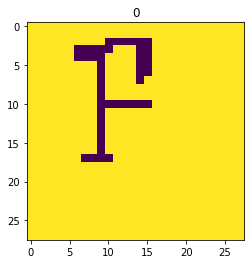

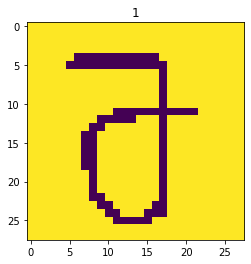

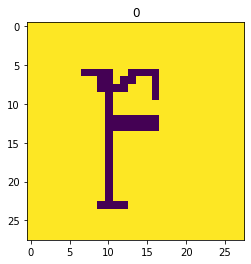

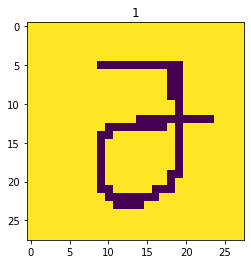

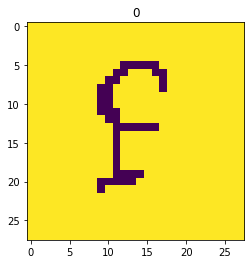

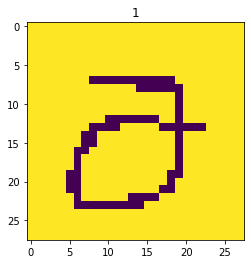

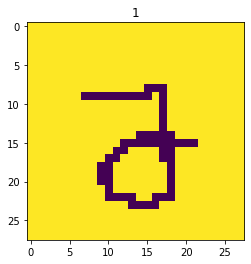

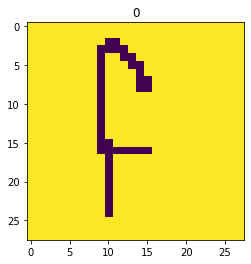

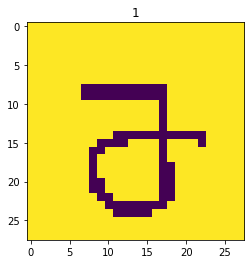

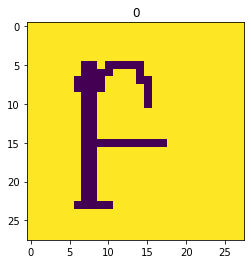

In [31]:
def create_dataset(imgs, ways, shots, tasks, classes=None):
    main_list_x = []
    main_list_y = []
    for task in range(tasks):
        task_list_x = []
        task_list_y = []
        for way in range(ways):
            no_langs = len(imgs)
            lang = randint(0, no_langs-1)
            no_chars = imgs[lang].shape[0]
            char = randint(0, no_chars-1)
            no_imgs = imgs[lang][char].shape[0]
            for img in range(shots):
                img_no = randint(0, no_imgs-1)
                cur_img = imgs[lang][char][img_no]
                task_list_x.append(cur_img,)
                task_list_y.append(way)
        size = shots*ways
        indices = np.random.choice(size, size, replace=False)
        task_list_x = np.array(task_list_x)
        task_list_y = np.array(task_list_y)
        task_list_x = task_list_x[indices]
        task_list_y = task_list_y[indices]
        main_list_x.append(task_list_x)
        main_list_y.append(task_list_y)
    return np.array(main_list_x), np.array(main_list_y)

data_train_x, data_train_y = create_dataset(imgs_train, 2, 5, 1)
data_test_x, data_test_y = create_dataset(imgs_test, 2, 5, 1)
print(data_train_x.shape, data_train_y.shape)
for i in range(0,10):
    print(collections.Counter(data_train_y[0]))
    fg, ax = plt.subplots()
    ax.imshow(data_train_x[0][i])
    ax.set_title(data_train_y[0][i])

Epoch=0 loss=0.691719, accuracy=0.500000
Epoch=100 loss=0.693147, accuracy=0.500000
Epoch=200 loss=0.693147, accuracy=0.500000
Epoch=300 loss=0.693147, accuracy=0.500000
Epoch=400 loss=0.693147, accuracy=0.500000
Epoch=500 loss=0.693147, accuracy=0.500000
Epoch=600 loss=0.693147, accuracy=0.500000
Epoch=700 loss=0.693147, accuracy=0.500000
Epoch=800 loss=0.693147, accuracy=0.500000
Epoch=900 loss=0.693147, accuracy=0.500000


Text(0, 0.5, 'training accuracy')

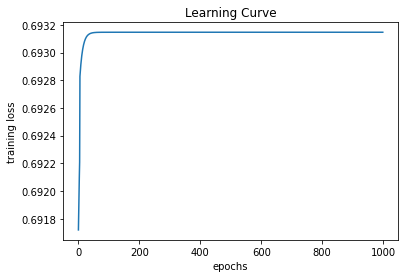

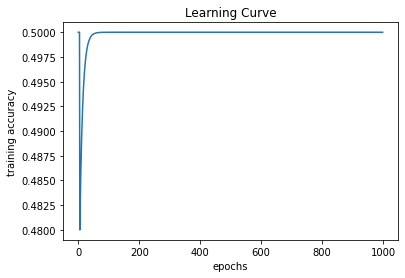

In [32]:
no_epochs = 1000
show_after = 100
update = 1
plot_accuracy = []
plot_loss = []
acc_on = (0,5)
nn = neural_network(ways = 2, shots = 5, feature_size=28*28, 
                    hidden_size=200, mem=(128, 40), nreads=2, batch=1)
for epoch in range(no_epochs):
    x, y, pred, loss = nn.run_episodes(imgs_train, create_dataset, MANN=True, LSTM=True, classes=None)
    if epoch%update:
        continue
    else:
        nn.stored_dataset = None
        #pass
    accuracy_dict = nn.accuracy(pred.reshape(-1, nn.ways), y. reshape(-1))
    correct_preds = 0
    for a, b in accuracy_dict.items():
            correct_preds+=sum(b[acc_on[0]:])
    plot_accuracy.append(correct_preds/(nn.ways*(acc_on[1]-acc_on[0])*nn.batch))
    plot_loss.append(loss.item())
    if epoch%show_after == 0:
        curr_lr = nn.optimizer.param_groups[0]['lr']
        print(f"Epoch=%d"%epoch, f"loss=%f, accuracy=%f"%(loss.item(), 
        (correct_preds/(nn.ways*(acc_on[1]-acc_on[0])*nn.batch))))
        #print(x, y, pred)
        #print(memory)
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
ax1.plot(smooth(plot_loss))
ax2.plot(smooth(plot_accuracy))
ax1.set_title('Learning Curve')
ax2.set_title('Learning Curve')
ax1.set_xlabel("epochs")
ax1.set_ylabel("training loss")
ax2.set_xlabel("epochs")
ax2.set_ylabel("training accuracy")